# Create Gaussian random fields with lya survey geometry to compute $C_{\ell}(k)$
- [x] generate GRFs with known Lya bias and beta
- [x] draw skewers through box
- [x] FFT (or discrete FT) of each skewer and construct $\delta_{2D}$ matrix
    - [x] matrix of shape: (N_qso x N_kbins), so that in row i: ($\delta_F(k_0), \dots,\delta_F(k_N)$)
- [x] compute $$a_{\ell m}(\mathbf{k}) = \sum_j^{N_q} \delta_{2D}(x,y,z,k_i)Y_{\ell m}^{\ast}(x,y,j)$$
- [x] compute $$\hat{C}_{\ell}(k_i) = \texttt{hp.alm2cl}(a_lm(k_i))$$
- [x] compare to theory
- [ ] repeat for different cases:
    1. periodic box w/ eBOSS-like Lya sampling of $\sim 30$ QSO/deg^2
    2. partial skewers
    2. partial skewers + 10 \% Gaussian random noise

In [1]:
%matplotlib inline
import os
import numpy as np
from matplotlib_params_file import *
import multiprocessing as mp
import healpy as hp

# GRFs
import GRF_class as my_GRF

# import function for SHT-lya
import SHT_lya as sht_lya

## create GRF

In [2]:
do_plots=True

# define GRF settings

# define number of qso drawn from the box
num_qso = int(1e+4)

# set `add_rsd=True' if you want to add RSD
add_rsd_=False

In [3]:
my_seed = 100
GRF = my_GRF.PowerSpectrumGenerator(add_rsd=add_rsd_, seed=my_seed)

In [ ]:
# # UNCOMMENT to compute power spectrum with mode counting in spherical shells
# k_eff, p0_hat, p2_hat, p4_hat, counts, totcounts = GRF.compute_power_spectrum()
# # theory power spectrum anisotropic
# p0, p2, p4 = GRF.get_multipoles()

# ### compare theory to measurement
# plt.figure()
# plt.plot(GRF.kh_lin, GRF.kh_lin*p0, 'b-', label=r'$\ell=0$ (aniso)')
# plt.plot(GRF.kh_lin, GRF.kh_lin*p2, 'g-', label=r'$\ell=2$ (aniso)')
# plt.plot(GRF.kh_lin, GRF.kh_lin*p4, 'm-', label=r'$\ell=4$ (aniso)')
# plt.plot(k_eff, k_eff*p0_hat, 'bo--',label=r'$\hat{P}_{\ell=0}^{\mathrm{aniso}}(k)$')
# plt.plot(k_eff, k_eff*abs(p2_hat), 'go--',label=r'$\hat{P}_{\ell=2}^{\mathrm{aniso}}(k)$')
# plt.plot(k_eff, k_eff*abs(p4_hat), 'mo--',label=r'$\hat{P}_{\ell=4}^{\mathrm{aniso}}(k)$')
# plt.xlabel(r'$k\,[h$Mpc$^{-1}]$')
# plt.ylabel(r'$k\,P_\ell(k)\,[h^{-2}$Mpc$^{2}]$')
# plt.legend(ncol=2);plt.xlim(0., 0.5);
# #plt.ylim(0., 320)
# plt.show()



### Sample skewers
- Note that we apply a shift along the z axis. This is necessary to ensure that the $\mu$ angle is with respect to the z-axis
- computes $\mu$ with respect to the combined line-of-sight; $(\vec{r}_i+\vec{r}_j)/2$

In [ ]:
# shift GRF box
chi_shift = 5000. # Mpc/h

all_x, all_y, all_z, all_w_rand, all_w_gal, Nskew = GRF.process_skewers(Nskew=num_qso, shift=chi_shift)

all_theta, all_phi = GRF.compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
chi_grid = all_x[0,:] # Mpc/h

Displacing box by 5.000e+03


In [52]:
# # we are swapping around axes --> still working somehow 
# all_z, all_y, all_x, all_w_rand, all_w_gal, Nskew = GRF.process_skewers(Nskew=num_qso, shift=chi_shift)
# all_theta, all_phi = GRF.compute_theta_phi_skewer_start(all_x[:,0], all_y[:,0], all_z[:,0])
# chi_grid = all_z[0,:] # Mpc/h

Displacing box by 5.000e+03


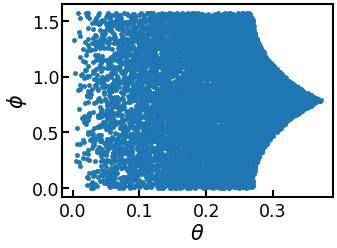

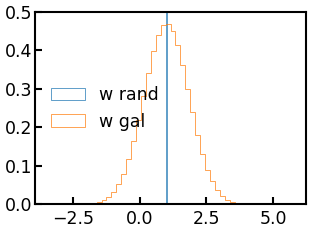

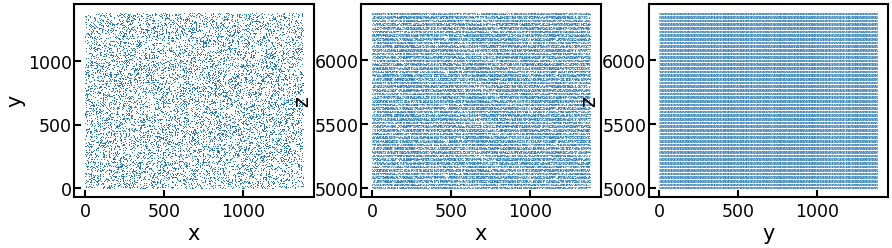

In [ ]:
if do_plots:
    # theta, phi positions of skewers in the sky 
    plt.figure(figsize=(7,5), dpi=50);plt.scatter(all_theta, all_phi);plt.xlabel(r'$\theta$');plt.ylabel(r'$\phi$');plt.show()

    ### Plot distribution of weights
    plt.figure(figsize=(7,5), dpi=50);
    plt.hist(all_w_rand.ravel(),density=True,histtype='step', bins=50, label='w rand');
    plt.hist(all_w_gal.ravel(),density=True, histtype='step',bins=50, label='w gal');
    plt.ylim(0., 0.5);plt.legend()
    plt.show()

    #### Visually check if skewers are taken through box
    # Create a figure with 3 subplots side by side
    fig, axs = plt.subplots(1, 3, figsize=(21, 5), dpi=50)
    plots = [(all_x, all_y, 'x', 'y'), (all_x, all_z, 'x', 'z'), (all_y, all_z, 'y', 'z')]
    for ax, (x, y, xlabel, ylabel) in zip(axs, plots):
        ax.scatter(x.ravel()[::100], y.ravel()[::100], s=0.1)
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
    plt.show()

#### Comment on $\langle (D-R)(D-R)\rangle$
For Lya, the term `randoms`is a misnomer and just encodes the window function. `directSHT` is a general framework for large-scale structure tracers, thus we keep that nomenclature and use the following form for the Lya data: $w_{\mathrm{D}} = w(\delta_F+1)$ and $w_{\mathrm{R}} = w$. This allows us to trivially extend this framework to cross-correlations of e.g., Lya x QSO. 

## compute discrete Fourier transform of matrix $N_{qso} \times N_{pix}$

- compute $\delta_{2D}(\hat{n}_j;k)$ for $\delta_{3D}=\delta_F(\chi\hat{n}_j)$ along each QSO sightline, $\hat{n}_j$, using FFTs [or as matrix-vector multiply of $\exp[ik\chi]$] with $K_j(\chi)\delta_F(\chi)$.
- Since the DESI QSO spectra all share a common wavelength grid, the ``matrix'' can be computed once.  It is convenient to store the real and imaginary parts separately.  
- same procedure on $K_j(\chi)$ not weighted by $\delta_F$ gives $\widetilde{K}_j(k)$.

- use $\delta_{2D}(\hat{n}_j;k)$ as weights for each QSO
- perform a spherical harmonic transform for each $k$
- For $\ell_{\rm max}=10^3$ and $10^6$ QSOs this takes a few seconds for each of the real and imaginary parts for each $k$.  
- Squaring the results and averaging over $m$ gives $C_\ell(k)$, which can be binned into bins of $\ell$ and normalized as desired.  

- compute the window matrix.  This is independent of the data, depending only upon the chosen weights, $K_j(\chi)$, and the QSO positions, $\hat{n}_j$.  If the matrix $\hat{n}_j\cdot\hat{n}_k$ is pre-computed, the sum over $\lambda$ can be done with recurrence relations and the final sum over $jk$ is a matrix product and trace though the final object depends upon $\ell$ (normally binned), $L$ and $k-k'$ and so can be large.  For very large numbers of sightlines, the sum over $j$ can be done in batches using the same procedure.


In [55]:
k_arr, FT_mask, FT_delta = sht_lya.compute_dft(chi_grid, all_w_rand, all_w_gal)

## Core computation of `directSHT-lya` to compute $C_{ell}(k)$


In [23]:
import sys
%env JAX_ENABLE_X64=True
#
#sys.path.insert(0, '/global/homes/r/rmvd2/lya_Cl/directsht-lya/')
sys.path.insert(0, '/Users/rdb/Desktop/research/lya/P3D_Cell/directsht-lya/')
from sht.sht                import DirectSHT
from sht.mask_deconvolution import MaskDeconvolution

try:
    from jax.lib import xla_bridge
    print(xla_bridge.get_backend().platform)
except:
    print("No GPU found")

env: JAX_ENABLE_X64=True
JAX not found. Falling back to NumPy.
JAX not found. Falling back to NumPy.
No GPU found


In [24]:
# Set up an sht instance.
Nl   = 500
Nx   = 2*Nl
xmax = 5.0/8.0
#
sht= DirectSHT(Nl,Nx,xmax)
#
# Here we don't go to higher lmax in W_l since we DO NOT mode-decouple --> no randoms for Lya (only mask and signal)
# buffer_ells = 64
# sht_randoms = DirectSHT(Nl,Nx,xmax)
# sht_randoms = DirectSHT(Nl+buffer_ells,Nx,xmax)
#
print("For general, Direct SHT has Nl=",sht.Nell,", Nx=",Nx," and xmax=",xmax)
# print("For randoms, Direct SHT has Nl=",sht_randoms.Nell,", Nx=",Nx," and xmax=",xmax)

For general, Direct SHT has Nl= 500 , Nx= 1000  and xmax= 0.625


In [56]:
tdata,pdata,wdata = all_theta, all_phi, FT_delta.real
trand,prand,wrand = all_theta, all_phi, FT_mask.real
print(f'Nskew = {Nskew}, Nk = {wrand.shape[1]}')

Nskew = 9797, Nk = 512


### measure $C_{\ell}(k)$ for different values of $k$

/Users/rdb/opt/anaconda3/envs/desi/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/rdb/opt/anaconda3/envs/desi/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/rdb/opt/anaconda3/envs/desi/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)
/Users/rdb/opt/anaconda3/envs/desi/lib/python3.9/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


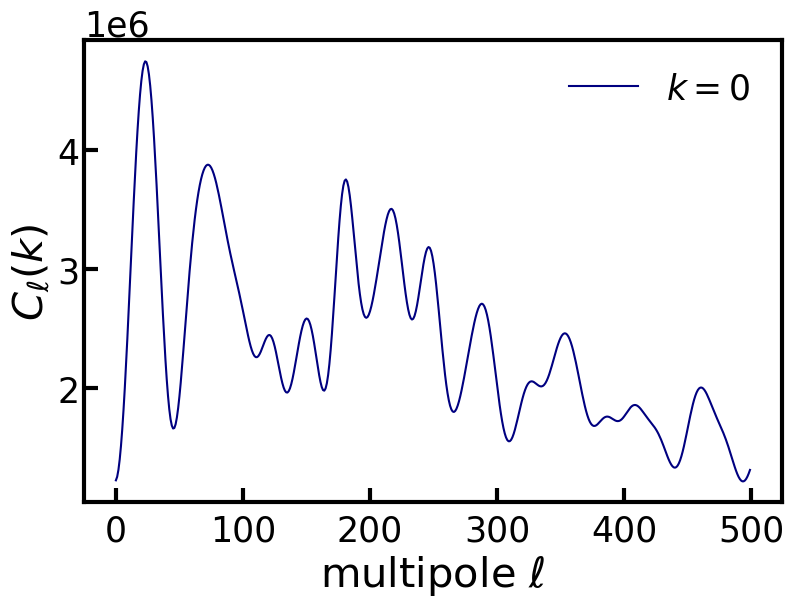

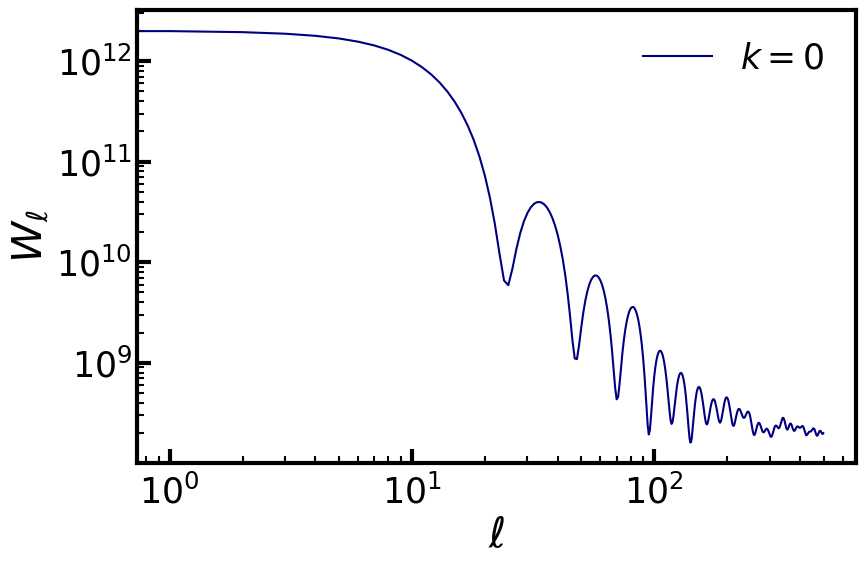

In [57]:
# define index for calculation 
k_idx = 0

# If i want to speed up for lya: only compute the difference directly in k-space
# _hdat = sht(tdata,pdata,wdata[:,_k_idx]-wrand[:,_k_idx])
# _hdif = hp.alm2cl(_hdat)

cl_k = []
wl_k = []
for _k_idx in np.arange(0, k_idx+1, 1):
    hdat = sht(tdata,pdata,wdata[:,_k_idx])
    # Do the same for the randoms.
    hran = sht(trand,prand,wrand[:,_k_idx])
    # Anton normalization for FKP-type weights
    # hran*= hdat[0]/hran[0]
    # and for the difference of data and randoms:
    hdif = hp.alm2cl(hdat-hran)
    wl = hp.alm2cl(hran)
    cl_k.append(hdif)
    wl_k.append(wl)
cl_k = np.stack(cl_k)
wl_k = np.stack(wl_k)

if do_plots:
    n = len(cl_k)
    colors = plt.cm.jet(np.linspace(0,1,n))
    plt.figure(figsize=(9,6))
    for _k_idx in range(len(cl_k)):
        plt.plot(np.arange(sht.Nell), cl_k[_k_idx],color=colors[_k_idx], label=f'$k={_k_idx}$')
    plt.xlabel(r'multipole $\ell$')
    plt.ylabel(r'$C_{\ell}(k)$')
    plt.legend()
    plt.show()

    plt.figure(figsize=(9,6))
    for _k_idx in range(len(cl_k)):
        plt.loglog(np.arange(sht.Nell), wl_k[_k_idx],color=colors[_k_idx], label=f'$k={_k_idx}$')
    plt.xlabel(r'$\ell$');plt.ylabel(r'$W_\ell$');plt.legend();plt.tight_layout()
    plt.savefig('./plots/harmonic_window.pdf')

## compute Wigner3j

In [58]:
precompute_Wigner3j = True
if precompute_Wigner3j:
    # Wigner3j code
    import fast_Wigner3j as Wigner3j

    #initialize class
    couple_mat = Wigner3j.CoupleMat(Nl, wl_k[_k_idx])
    coupling_matrix = couple_mat.compute_matrix()

    MD = MaskDeconvolution(Nl,wl_k[_k_idx],precomputed_Wigner=coupling_matrix)
else:
    # if I want to use SHT for the Wigner3j computation
    print('use SHT native Wigner3j computation')
    %time MD = MaskDeconvolution(Nl,wl_k[_k_idx])
#
# choose binning for Cell's
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# # Look at the sums over ell.
# print("\nRow sums of Mbl:")
# print(Mbl.sum(axis=1))

print('cross checks ')
print(np.allclose(coupling_matrix, MD.Mll))

read in Wigner 3j matrix
cross checks 
True


### plot coupling matrix and window func

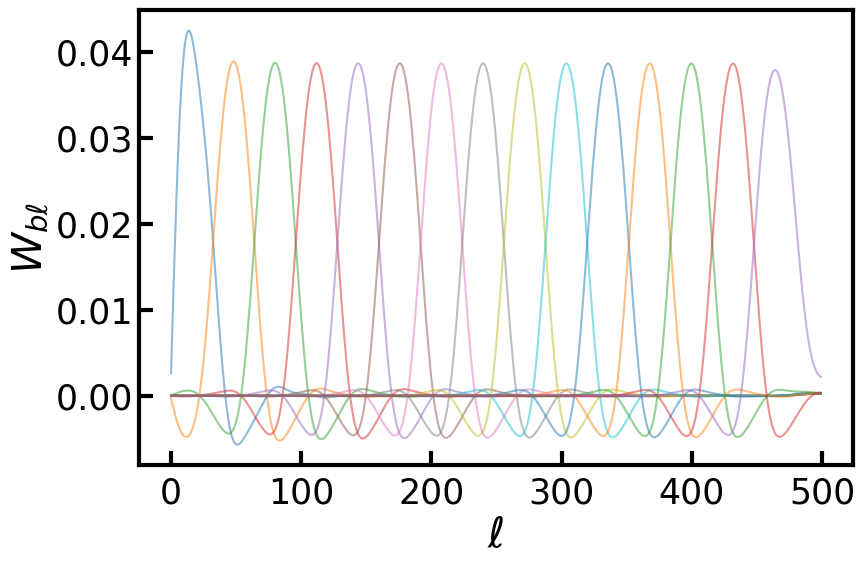

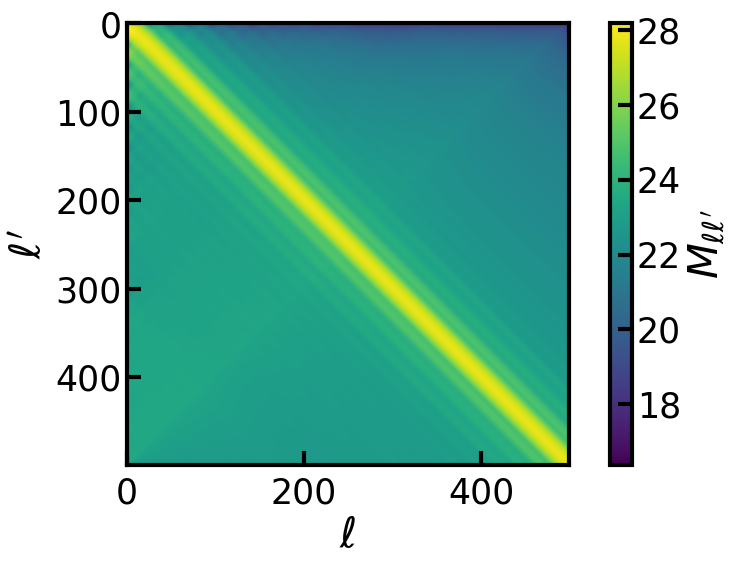

In [59]:
if do_plots:
    # Plot the matrix:
    fig,ax = plt.subplots(1,1, figsize=(9,6))
    for i in range(Mbl.shape[0]):
        ax.plot(Mbl[i,:],alpha=0.5,label='Bin '+str(i))
    #ax.legend(bbox_to_anchor=(1.1,1.0))
    #ax.set_ylim(-0.07, 0.07)
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$W_{b\ell}$')
    plt.tight_layout()
    plt.savefig('./plots/harmonic_wbl.pdf', bbox_inches='tight')
    #
    # and plot the mode-coupling matrix itself.
    fig,ax = plt.subplots(1,1, figsize=(9,6))
    mode_coupling = np.log( 1+MD.Mll.clip(0,1e30) )
    im = ax.imshow(mode_coupling.T)
    ax.set_xlabel(r'$\ell$')
    fig.colorbar(im, label=r'$M_{\ell \ell^\prime}$')
    ax.set_ylabel(r'$\ell^\prime$')
    plt.tight_layout()
    plt.savefig('./plots/harmonic_mll.pdf', bbox_inches='tight')

### deconvolve window from theory
- Not recommended for Lya 

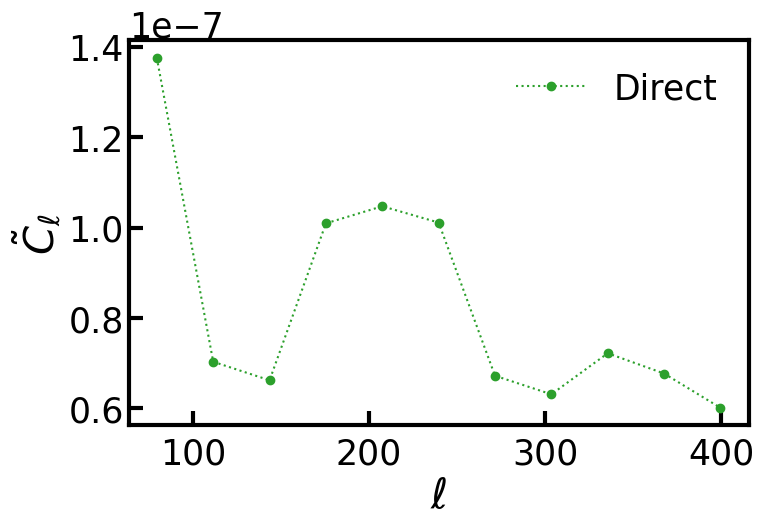

In [60]:
# Now work out the binned and decoupled pseudo-spectrum.
# The first Ndiscard bins are removed because they have
# support to very low ell and the last bins because
# they have support past lmax
Ndiscard = 2
binned_ells,hdif_decoupled = MD(hdif,bins)
binned_ells,hdif_decoupled = binned_ells[Ndiscard:-Ndiscard],hdif_decoupled[Ndiscard:-Ndiscard]

if do_plots:
    # we don't want to deconvolve the theory
    fig,ax = plt.subplots(1,1,figsize=(8,5))
    ax.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')
    # Compare to the theory convolved with the bandpower window function -- we
    # expect some differences due to sample variance, but they shouldn't be huge.
    # clt_conv = np.dot(Mbl,cl_theory[:Mbl.shape[1]])
    # ax.plot(binned_ells, clt_conv[Ndiscard:-Ndiscard],'o:',color='C1',label='Theory')
    ax.set_xlabel(r'$\ell$')
    ax.set_ylabel(r'$\tilde{C}_\ell$')
    ax.legend()
    plt.savefig('./plots/harmonic_tildeC.pdf', bbox_inches='tight')

# compute theory power spectrum 
$$\Large  C_\ell(k)  = \sum_{L \lambda}  F_{\ell L \lambda} \int\frac{dk'}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k') \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k-k')\widetilde{K}_k(k-k') $$
Let's do the computation for a $\textbf{periodic}$ box:
- we use the definition of $$ F_{\ell L \lambda} = \frac{(2L+1)(2\lambda+1)}{(4\pi)^2} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2 $$
- using a periodic box, the $\widetilde{K}_j$ acts like a $\delta$ function
$$ C_\ell(k'=0)  = \sum_{L \lambda}  F_{\ell L \lambda} \frac{1}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k=0) \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k'=0)\widetilde{K}_k(k'=0) = \sum_{L \lambda}  F_{\ell L \lambda} \frac{1}{2\pi\,\bar{\chi}^2}\ P_L P_\lambda N_k^2$$
$$ =\frac{1}{4\pi} \sum_{L} \left((2L+1) \sum_{\lambda} \frac{(2\lambda+1)}{4\pi} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2 P_\lambda N_k^2\right) \frac{P_L}{2\pi\,\bar{\chi}^2} $$
we swap $\lambda$ and $L$ ordering (which does not change anything since the Wigner 3j symbols are squared):
$$ =\frac{1}{4\pi} \sum_{\lambda} \left((2\lambda+1) \sum_{L} \frac{(2L+1)}{4\pi} \begin{pmatrix} \ell & \lambda& L \\ 0&0&0 \end{pmatrix}^2 P_L\right) \frac{P_\lambda N_k^2}{2\pi\,\bar{\chi}^2} = \frac{1}{4\pi} \sum_{\lambda} M_{\ell \lambda} \frac{P_{\lambda}N_k^2}{2\pi\overline{\chi}^2}$$

where we use $M_{\ell L} = (2L+1)\sum_{\lambda} \frac{(2\lambda+1)}{ (4\pi)} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2  P_{\lambda}$
which reduces the current computation to matrix products. Now, if we want to forward model the window, we apply the usual procedure
$$\hat{C}_{\ell}=\sum_{\ell'}M_{\ell \ell'}\left(\sum_{L} \frac{1}{2\pi\,\bar{\chi}^2} \frac{M_{\ell' L }}{ (4\pi)} P_L\right)$$
and using the inequality 
$ \vert \ell - \lambda \vert \leq L \leq \vert \ell + \lambda \vert $ where $0 \leq \ell \leq 500$, $0 \leq \lambda \leq 500$ and $0 \leq L \leq 1000$.

In [61]:
#lambda_min, lambda_max = sht_lya.compute_Wigner3j_symmetry_range(Nl, Nl)
lambda_max = Nl
L_max = 2*Nl

periodic=True

# Compute nhat
nhat = sht_lya.compute_nhat(tdata, pdata)
# Compute cos(theta_nj_nk)
cos_theta_njnk = np.dot(nhat, nhat.T)

if periodic:
    KjKk = GRF.N**2
else:
    KjKk = np.outer(FT_mask[:, k_idx], FT_mask[:, k_idx])

#test run to initialize numba 
_my_result = sht_lya.legendre_polynomials_sum(1, cos_theta_njnk,KjKk)

print('compute the Legendre polynomials sum times the mask')
%time PLKjKk = sht_lya.legendre_polynomials_sum(lambda_max, cos_theta_njnk, KjKk)[:-1]
print('done')

compute the Legendre polynomials sum times the mask
CPU times: user 4min 58s, sys: 6min 45s, total: 11min 44s
Wall time: 2min 20s
done


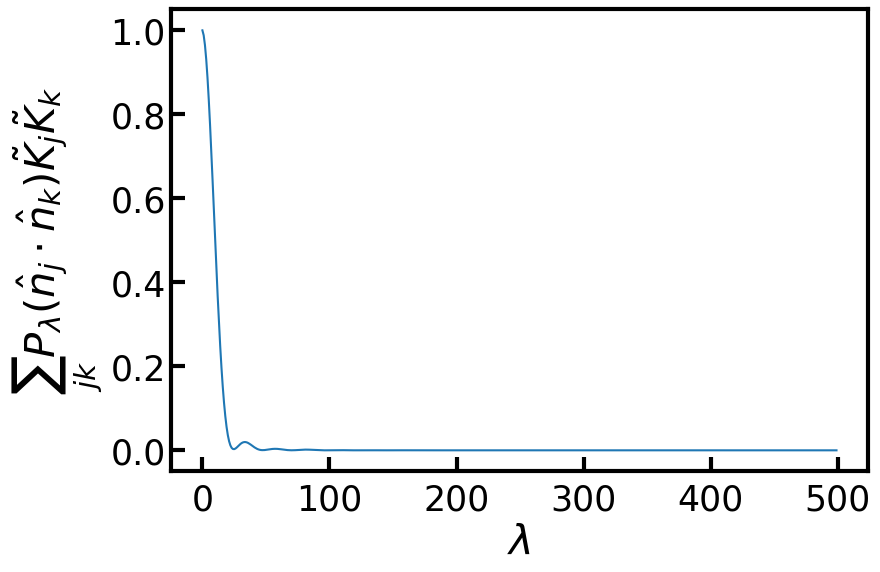

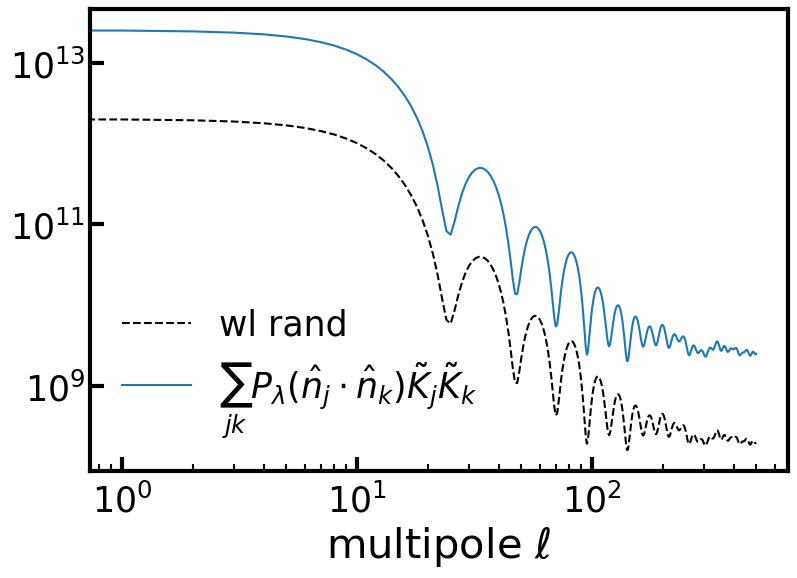

In [62]:
#np.savetxt('./data/PLKjKk_lambdamax_200.txt', PLKjKk)
#PLKjKk = np.loadtxt('./data/PLKjKk_lambdamax_200.txt')/Nskew**2/Nskew**2
# PLKjKk = np.loadtxt('./data/PLKjKk_lambdamax_200_old.txt')/Nskew**2

if do_plots:
    plt.figure(figsize=(9,6))
    #normalized by Nskew^2 * Ncell^2
    plt.plot(PLKjKk/GRF.N**2/Nskew**2)
    plt.xlabel(r'$\lambda$')
    plt.ylabel(r'$\sum_{jk}P_{\lambda}(\hat{n}_j \cdot \hat{n}_k) \tilde{K}_j\tilde{K}_k$')
    plt.savefig('./plots/legendre_polynomials.pdf', bbox_inches='tight')
    plt.show()

    plt.figure(figsize=(9,6))
    plt.loglog(wl_k[_k_idx],'k--', label='wl rand')
    plt.loglog(PLKjKk, label=r'$\sum_{jk}P_{\lambda}(\hat{n}_j \cdot \hat{n}_k) \tilde{K}_j\tilde{K}_k$')
    plt.xlabel(r'multipole $\ell$')
    plt.legend()

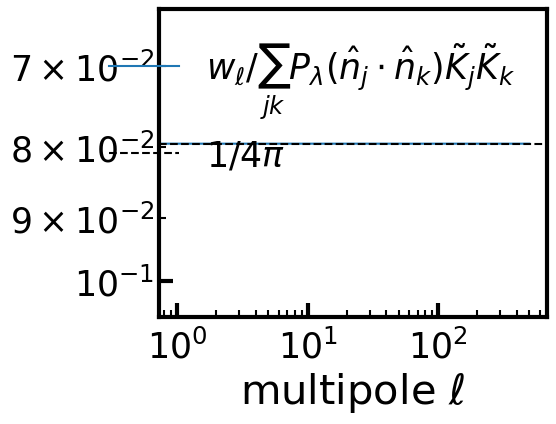

In [63]:
plt.figure(figsize=(5,4))
plt.loglog(wl_k[_k_idx]/PLKjKk[:Nl], label=r'$w_\ell/\sum_{jk}P_{\lambda}(\hat{n}_j \cdot \hat{n}_k) \tilde{K}_j\tilde{K}_k$')
plt.axhline(1/4/np.pi, color='k', linestyle='--', label=r'$1/4\pi$')
plt.ylim(1/3/np.pi, 1/5/np.pi)
plt.xlabel(r'multipole $\ell$')
plt.legend()

In [64]:
def Power_spectrum(kh_perp, kh_par, add_rsd=add_rsd_):
    kh = np.sqrt(kh_par**2 + kh_perp**2)
    pk = GRF.plin(kh)
    Kaiser_factor = 1.
    if add_rsd:
        mu = kh_par / kh
        Kaiser_factor = GRF.my_bias**2 * (1. + GRF.my_beta * mu**2)**2
    # print(kh, pk)
    return Kaiser_factor * pk

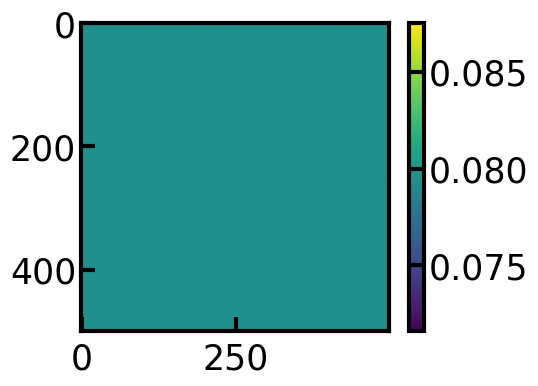

In [65]:
plt.figure(figsize=(5,4));plt.imshow(coupling_matrix/MD.Mll/(4*np.pi));plt.colorbar();plt.show()

compute for k index: 0 with chibar:  5690.0 and 1/(2 pi chi^2)=4.92e-09


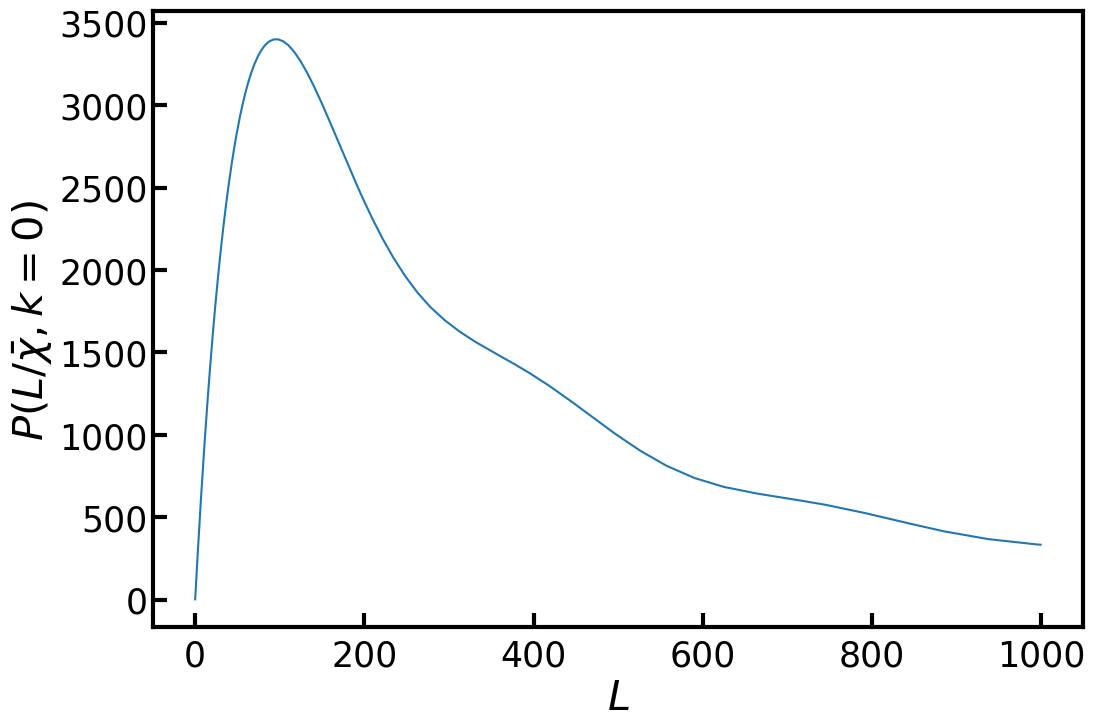

In [66]:
# is the L range sufficient?
L_range = np.arange(0, L_max, 1)

# is chi bar approx correct?
chi_bar = (chi_grid.max()+chi_grid.min())/2
print('compute for k index:', k_idx, 'with chibar: ', chi_bar, f'and 1/(2 pi chi^2)={(1/(2.*np.pi*chi_bar**2)):.2e}')

# Limber approx for power spec
pk_L = Power_spectrum(kh_perp=L_range/chi_bar, kh_par=k_arr[k_idx])

if do_plots: plt.plot(pk_L);plt.xlabel(r'$L$');plt.ylabel(r'$P(L/\bar{\chi}, k=0)$');plt.show()

$$ C_\ell(k'=0)  = \sum_{L \lambda}  F_{\ell L \lambda} \frac{1}{2\pi\,\bar{\chi}^2}\ P(L/\bar{\chi},k=0) \sum_{jk} P_\lambda(\hat{n}_j\cdot\hat{n}_k) \widetilde{K}_j^\star(k'=0)\widetilde{K}_k(k'=0) = \sum_{L \lambda}  F_{\ell L \lambda} \frac{1}{2\pi\,\bar{\chi}^2}\ P_L P_\lambda N_k^2$$
$$ =\frac{1}{4\pi} \sum_{L} \left((2L+1) \sum_{\lambda} \frac{(2\lambda+1)}{4\pi} \begin{pmatrix} \ell & L & \lambda \\ 0&0&0 \end{pmatrix}^2 P_\lambda N_k^2\right) \frac{P_L}{2\pi\,\bar{\chi}^2} $$
we swap $\lambda$ and $L$ ordering (which does not change anything since the Wigner 3j symbols are squared):
$$ =\frac{1}{4\pi} \sum_{\lambda} \left((2\lambda+1) \sum_{L} \frac{(2L+1)}{4\pi} \begin{pmatrix} \ell & \lambda& L \\ 0&0&0 \end{pmatrix}^2 P_L\right) \frac{P_\lambda N_k^2}{2\pi\,\bar{\chi}^2} = \frac{1}{4\pi} \sum_{\lambda} M_{\ell \lambda} \frac{P_{\lambda}N_k^2}{2\pi\overline{\chi}^2}$$

In [67]:
# compute F_{ell L lambda} matrix
# couple_mat = Wigner3j.CoupleMat(Nl, PLKjKk)
# coupling_matrix_leg_pol = couple_mat.compute_matrix()

couple_mat = Wigner3j.CoupleMat(Nl, pk_L)
coupling_matrix_pk_L = couple_mat.compute_matrix()

# couple_mat = Wigner3j.CoupleMat(Nl, wl_k[_k_idx])
# coupling_matrix_window = couple_mat.compute_matrix()

In [68]:
#theory power spectrum
C_ell = np.dot(coupling_matrix_pk_L, PLKjKk)/(4.*np.pi)/(2.*np.pi*chi_bar**2)
# window convolved theory power spectrum
# C_ell_hat = np.dot(coupling_matrix_window, C_ell) #[:MD.Mll.shape[1]]

# binning
ells = np.arange(Nl)
my_binned_ells = np.dot(bins, ells)

# bin theory Cell's
binned_C_ell = bins @ C_ell#[:MD.Mll.shape[1]]
# bin theory window func convolved Cell's
# binned_C_ell_hat = bins @ C_ell_hat
# bin measured Cell's
binned_hdif = bins @ cl_k[_k_idx]


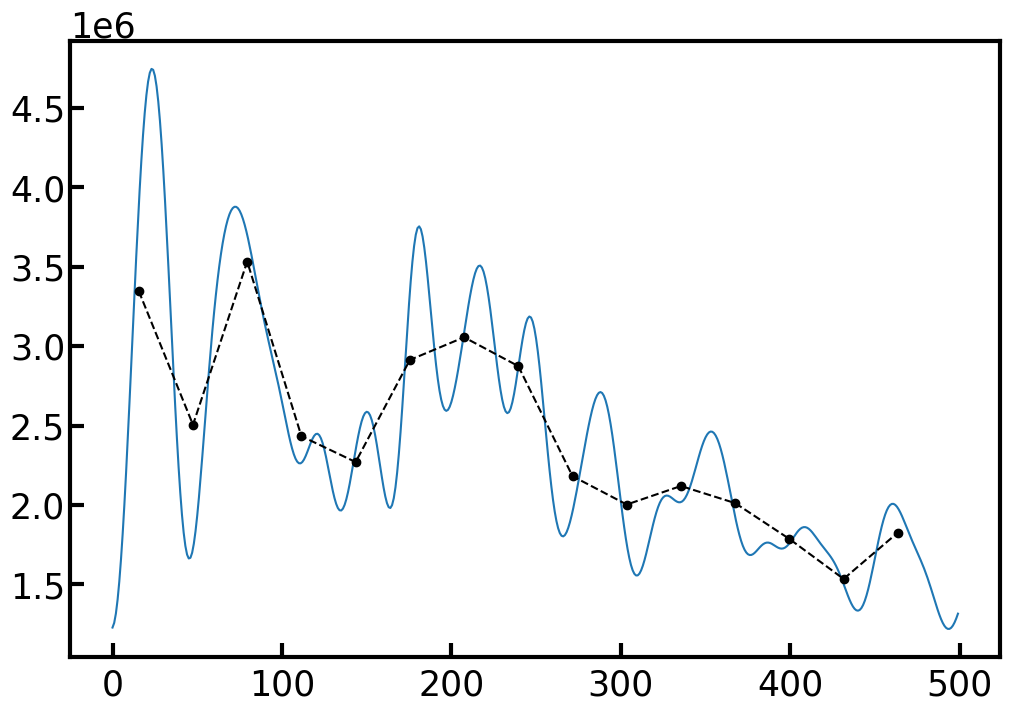

In [69]:
plt.plot(ells, cl_k[_k_idx])
plt.plot(my_binned_ells, binned_hdif, 'ko--')

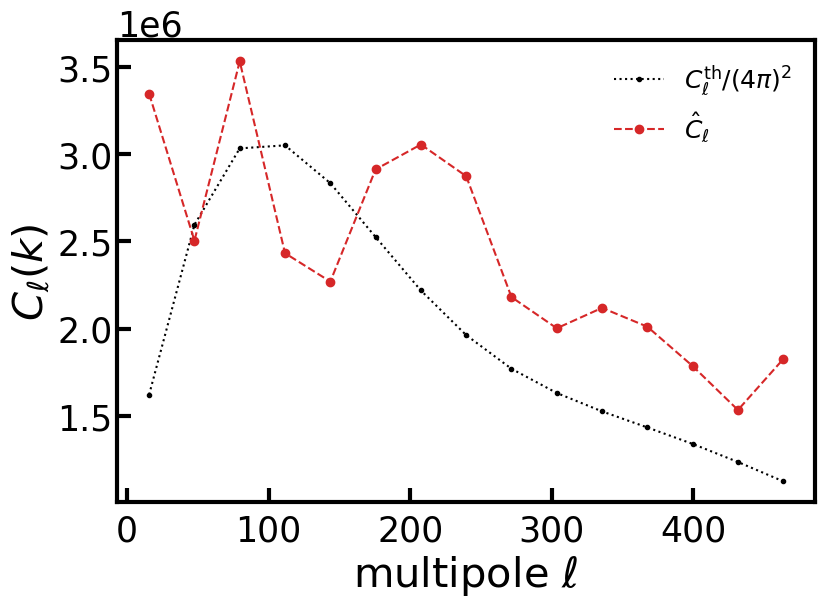

In [70]:
norm_Plambda = PLKjKk[0]

if do_plots:
    # plt.figure(figsize=(9,6))
    # plt.plot(ells, C_ell[:Nl],'k-', label=r'$C_{\ell}^{\rm th}$ (no binning)')
    # plt.plot(my_binned_ells, binned_C_ell, 'k.:', label=r'$C_{\ell}^{\rm th}$')
    # # plt.plot(my_binned_ells, binned_C_ell_hat/norm_Plambda,'k--',label=r'window conv $\hat{C}_{\ell}^{\rm th}/P_{\lambda=0}$')
    # plt.xlabel(r'multipole $\ell$')
    # plt.ylabel(r'$C_{\ell}(k)$')
    # plt.legend()
    # plt.show()

    plt.figure(figsize=(9,6))
    plt.plot(my_binned_ells, binned_C_ell/(4*np.pi)**2, 'k.:', label=r'$C_{\ell}^{\rm th}/(4\pi)^2$')
    # plt.plot(my_binned_ells, binned_C_ell/120, 'ko--', label=r'$C_{\ell}^{\rm th}/120$')
    # plt.plot(my_binned_ells, binned_C_ell_hat/Nskew**2/GRF.N**2/(4*np.pi)**2,'k--',label=r'$\hat{C}_{\ell}^{\rm th}/N_q^2/N_k^2/(4\pi)^2$')
    # plt.plot(my_binned_ells, binned_C_ell_hat/norm_Plambda/(4*np.pi)**2,'k.:',label=r'$\hat{C}_{\ell}^{\rm th}/P_{\lambda=0}/(4\pi)^2$')
    # plt.plot(ells, hdif*(4*np.pi)**2,'C3-', label=r'$\hat{C}_{\ell} (4\pi)^2$')
    plt.plot(my_binned_ells, binned_hdif,'C3o--', label=r'$\hat{C}_{\ell}$')
    plt.xlabel(r'multipole $\ell$')
    plt.ylabel(r'$C_{\ell}(k)$')
    plt.legend(ncol=1, fontsize=18, loc='upper right')
    plt.show()




## load pre-computed measurement for N GRF's

In [226]:
L_GRF = 1380.0
N_GRF=512
Nskew = 9797
num_sim=50
Nl = 500
cl_k = np.load(f'./data/cl_k_GRF_L{int(GRF.L):d}_N{int(GRF.N):d}_Nq{int(Nskew):d}_Nl{int(Nl):d}_sims{int(num_sim):d}.npy')

# load wl
wl = np.load(f'./data/wl_GRF_L{int(GRF.L):d}_N{int(GRF.N):d}_Nq{int(Nskew):d}_Nl{int(Nl):d}_sims{int(1):d}.npy')


In [227]:
#initialize class
couple_mat = Wigner3j.CoupleMat(Nl, wl)
coupling_matrix = couple_mat.compute_matrix()

MD = MaskDeconvolution(Nl,wl,precomputed_Wigner=coupling_matrix)
#
# choose binning for Cell's
NperBin = 2**5
bins    = MD.binning_matrix('linear',0,NperBin)
Mbl     = MD.window_matrix(bins)
# # Look at the sums over ell.
# print("\nRow sums of Mbl:")
# print(Mbl.sum(axis=1))

print('cross checks ')
print(np.allclose(coupling_matrix, MD.Mll))

Cl_hat_GRF = np.dot(coupling_matrix, C_ell) #[:MD.Mll.shape[1]]
binned_Cl_hat_GRF = bins @ Cl_hat_GRF

read in Wigner 3j matrix
cross checks 
True


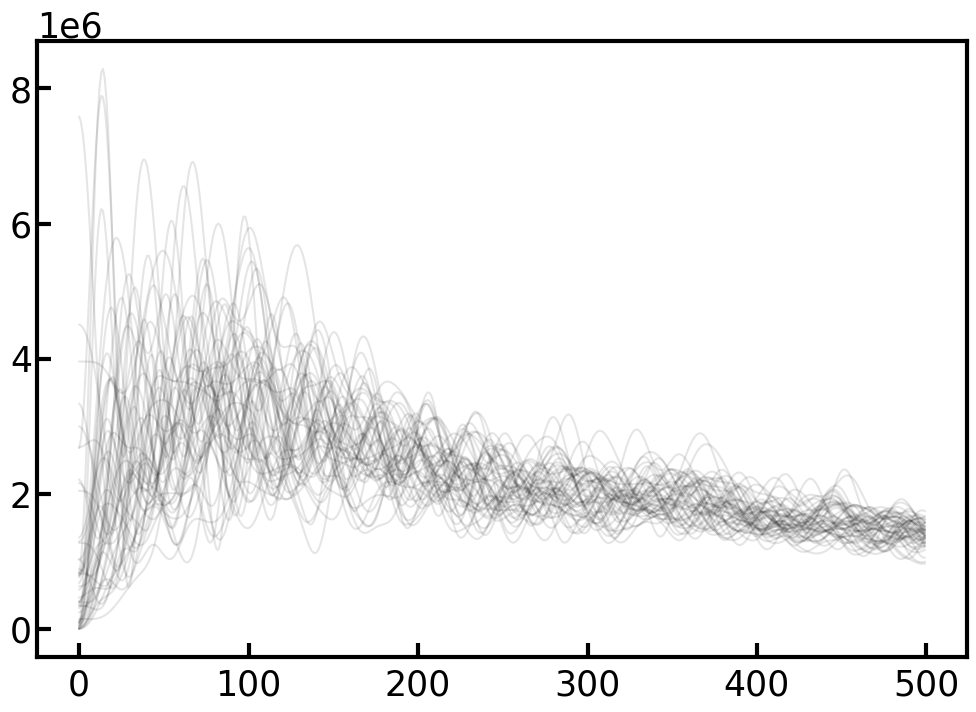

In [228]:
binned_clk = []
for i in range(num_sim):
    plt.plot(cl_k[i],'k-', alpha=0.1)
    binned_clk.append(bins @ cl_k[i])
binned_clk = np.stack(binned_clk)
binned_clk_mean = np.mean(binned_clk, axis=0)
binned_clk_std = np.std(binned_clk, axis=0)

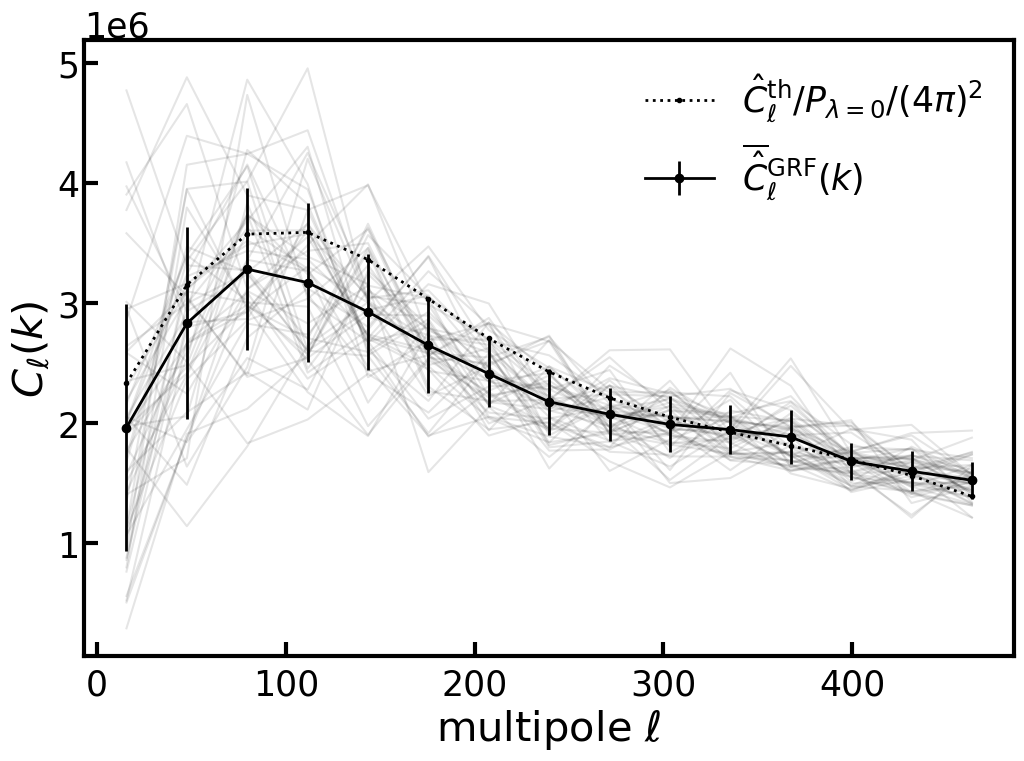

In [229]:
for i in range(num_sim):
    # plt.plot(ells, cl_k[i],'k-', alpha=0.1)
    plt.plot(my_binned_ells, bins @ cl_k[i],'k-', alpha=0.1)
plt.errorbar(my_binned_ells, binned_clk_mean, yerr=binned_clk_std,c='k', ls='-',fmt='o', lw=2, label=r'$\overline{\hat{C}}_{\ell}^{\rm GRF}(k)$')
plt.plot(my_binned_ells, binned_Cl_hat_GRF/norm_Plambda/(4*np.pi)**2,'k.:',lw=2, label=r'$\hat{C}_{\ell}^{\rm th}/P_{\lambda=0}/(4\pi)^2$')
plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.legend()
plt.show()

(50, 15)

# OLD CODE -- IGNORE

In [42]:

if __name__ == "__main__":
    #ell_range = np.concatenate([np.arange(2, 100, 10)])
    ell_range = np.concatenate([np.arange(2, 100, 1)])

    lambda_max = len(PLKjKk)
    L_min, L_max = compute_Wigner3j_symmetry_range(ell_range.max(), lambda_max)

    k_idx = 0
    Cl_int = np.zeros((len(ell_range), len(k_arr[:k_idx])+1))

    chi_bar = (chi_grid.max()+chi_grid.min())/2
    print('compute for k index:', k_idx, 'with chibar: ', chi_bar)

    # only compute C_ell(k=0) for now
    for ell_idx,ell_val in enumerate(ell_range):
        if ell_val % 20 == 0: print('compute for ell = ', ell_val)
        for L in range(L_min, L_max):
            for lambda_ in range(lambda_max):
                # print('compute for ell = ', ell_val, ' L=', L, 'and lambda=', lambda_)
                Cl_int[ell_idx, k_idx] += F_ell_L_lambda(ell_val, L, lambda_)*Power_spectrum(kh_perp=L/chi_bar, kh_par=k_arr[k_idx])/(2.*np.pi*chi_bar**2) * PLKjKk[lambda_]
    Cl_int = np.array(Cl_int).flatten()

In [181]:
def compute_single_ell(ell_idx, ell_val, L_min, L_max, lambda_max, k_idx, k_arr, chi_bar, PLKjKk):
    result = 0.0
    for L in range(L_min, L_max):
        for lambda_ in range(lambda_max):
            result += (F_ell_L_lambda(ell_val, L, lambda_) * 
                       Power_spectrum(kh_perp=L/chi_bar, kh_par=k_arr[k_idx]) / 
                       (2. * np.pi * chi_bar ** 2) * 
                       PLKjKk[lambda_])
    return ell_idx, result

if __name__ == "__main__":
    # ell_range = np.concatenate([np.arange(2, 100, 10)])
    ell_range = np.concatenate([np.arange(Nl+buffer_ells)])

    lambda_max = len(PLKjKk)
    L_min, L_max = compute_Wigner3j_symmetry_range(ell_range.max(), lambda_max)

    k_idx = 0
    Cl_int = np.zeros((len(ell_range), len(k_arr[:k_idx]) + 1))

    chi_bar = (chi_grid.max() + chi_grid.min()) / 2
    print('compute for k index:', k_idx, 'with chibar: ', chi_bar)

    # Prepare arguments for multiprocessing
    tasks = [(ell_idx, ell_val, L_min, L_max, lambda_max, k_idx, k_arr, chi_bar, PLKjKk) 
             for ell_idx, ell_val in enumerate(ell_range)]

    num_cpu=20
    # Use multiprocessing Pool
    with mp.Pool(num_cpu) as pool:
        results = pool.starmap(compute_single_ell, tasks)

    # Collect results
    for ell_idx, result in results:
        Cl_int[ell_idx, k_idx] = result
    Cl_int = np.array(Cl_int).flatten()
    
    print("Computation completed.")


compute for k index: 0 with chibar:  5690.0
Computation completed.


In [182]:
# np.savetxt('./data/Cl_int_k0_lambdamax_200_ellmax_564.txt', Cl_int)

In [43]:
Cl_int = np.loadtxt('./data/Cl_int_k0_lambdamax_200_ellmax_564.txt')

In [184]:
# np.savetxt('./data/Cl_int_k0_lambdamax_200.txt', Cl_int)

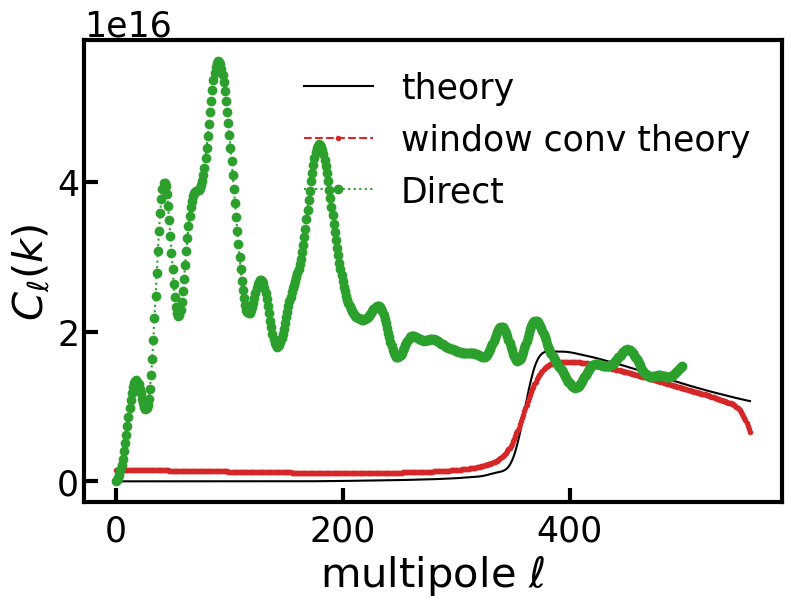

In [64]:
plt.figure(figsize=(9,6))
plt.plot(np.arange(len(Cl_int[Ndiscard:-Ndiscard])), Cl_int[Ndiscard:-Ndiscard],'k-',label='theory')
# Compare to the theory convolved with the bandpower window function
clt_conv = np.dot(MD.Mll,Cl_int[:MD.Mll.shape[1]])/3e+13
plt.plot(clt_conv[Ndiscard:-Ndiscard],'C3.--',label='window conv theory')

plt.plot(hdif*1e+10,'o:',color='C2',label='Direct')

plt.xlabel(r'multipole $\ell$')
plt.ylabel(r'$C_{\ell}(k)$')
plt.legend()
plt.show()

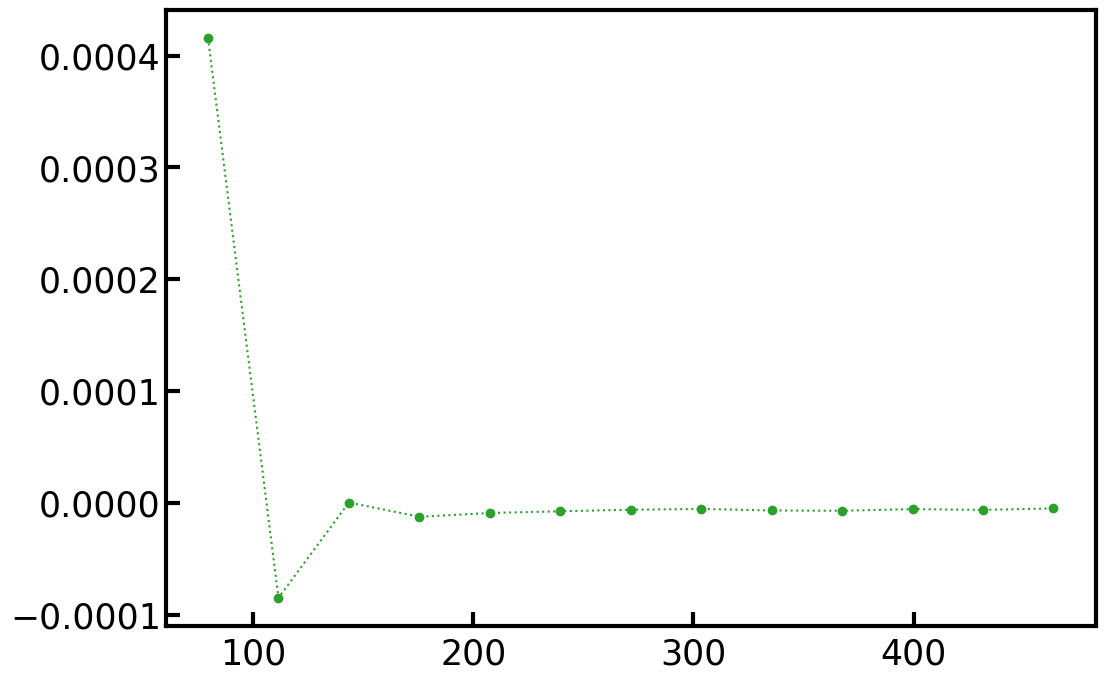

In [195]:
plt.plot(binned_ells,hdif_decoupled,'o:',color='C2',label='Direct')